In [1]:
import os
import json
from mathutils import Matrix
import numpy as np
from scipy.spatial.transform import Rotation

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import Rectangle
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

In [47]:
# Specify the path to the dataset folder
dataset_path = 'data/3RScan'

scenes = {}

for scan_folder in os.listdir(dataset_path):
    scan_folder_path = os.path.join(dataset_path, scan_folder)

    # Check if the folder contains semseg.v2.json file
    semseg_file = os.path.join(scan_folder_path, 'semseg.v2.json')
    if not os.path.isfile(semseg_file):
        continue

    # Read and parse the semseg.v2.json file
    with open(semseg_file, 'r') as file:
        semseg_data = json.load(file)

    scan_id = semseg_data['scan_id']
    seg_groups = semseg_data['segGroups']
    
    extracted_objects = []

    # Extract individual objects
    for object_data in seg_groups:
        obj = {}
        # Extract necessary data from JSON
        axes_lengths = object_data['obb']['axesLengths']
        centroid = object_data['obb']['centroid']
        normalized_axes = object_data['obb']['normalizedAxes']
        
        rotation_matrix = np.transpose(np.array(normalized_axes).reshape(3, 3))
        rotation = Rotation.from_matrix(rotation_matrix)
        euler_angles = rotation.as_euler('xyz', degrees=False) # degrees in radians
        #quaternion = rotation.as_quat()
        
        if (object_data['label'] != 'wall') and (object_data['label'] != 'tv') and (object_data['label'] != 'commode') and (object_data['label'] != 'table') and (object_data['label'] != 'beanbag') and (object_data['label'] != 'light') and (object_data['label'] != 'sofa'):
            continue
        
        # Print the extracted data for each object
        print("Object ID:", object_data['objectId'])
        obj['id'] = object_data['objectId']
        print("Label:", object_data['label'])
        print("Location:", centroid)
        obj['location'] = centroid
        print("Size:", axes_lengths)
        obj['size'] = axes_lengths
        print("Euler Angles:", euler_angles)
        obj['euler_angles'] = euler_angles
        obj['rotation_matrix'] = rotation_matrix
        #print("Quaternion:", quaternion)
        #obj['quaternion'] = quaternion
        
        print("---")

        extracted_objects.append(obj)
    
    scenes[scan_id] = extracted_objects

Object ID: 14
Label: wall
Location: [-0.5973530983700146, -2.555398581097461, 0.2100500473368907]
Size: [4.43563043578445, 3.2909999350234864, 0.214380383343314]
Euler Angles: [1.57079633 0.         2.34179882]
---
Object ID: 3
Label: wall
Location: [-1.1051522876580964, 0.3544662283574396, 0.21000003904104192]
Size: [3.9398105232542577, 3.279999898076058, 1.1186110857208948]
Euler Angles: [ 1.57079633e+00 -2.22044605e-16  8.54508081e-01]
---
Object ID: 18
Label: beanbag
Location: [0.7093942180180628, -0.27473914115642106, -1.265169944275096]
Size: [0.658106470914923, 0.2909200126472113, 0.5608304339063951]
Euler Angles: [1.57079633 0.         0.57495783]
---
Object ID: 25
Label: commode
Location: [1.9954530776181225, -0.4546038783911397, -1.0031949597628038]
Size: [1.332212181411663, 0.853609900468366, 0.49757673354321763]
Euler Angles: [1.57079633 0.         2.33453657]
---
Object ID: 24
Label: tv
Location: [2.060328625199193, -0.29500910978741124, -0.15999998725950704]
Size: [1.3341

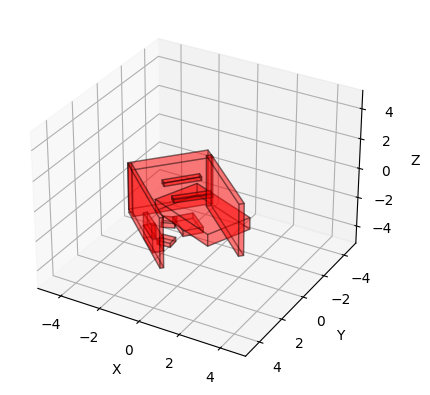

In [48]:
# Create a 3D plot
fig1 = plt.figure()
ax = fig1.add_subplot(111, projection='3d')

i = 0

# Visualize objects in the scene
for object_data in scenes['4acaebcc-6c10-2a2a-858b-29c7e4fb410d']:
    # Extract necessary data from the object
    location = object_data['location']
    size = object_data['size']
    euler_angles = object_data['euler_angles']
    #quaternion = object_data['quaternion']
    
    i = i+1
    if i > 20:
        break
    
    rotation = Rotation.from_euler('xyz', euler_angles)
    rotation_matrix = rotation.as_matrix()


    # Compute half-lengths along each axis
    half_lengths = np.array(size) / 2

    # Define relative coordinates of object's corners in local frame
    corners = np.array([
        [-1, -1, -1],  # Corner 1
        [-1, -1, 1],   # Corner 2
        [-1, 1, -1],   # Corner 3
        [-1, 1, 1],    # Corner 4
        [1, -1, -1],   # Corner 5
        [1, -1, 1],    # Corner 6
        [1, 1, -1],    # Corner 7
        [1, 1, 1]      # Corner 8
    ])
    scaled_corners = corners * half_lengths
    #relative_corners = np.transpose(corners * half_lengths)
    relative_corners = np.transpose(scaled_corners)

    relative_corners_4 = np.vstack((relative_corners, np.ones(relative_corners.shape[1])))


    transformation_matrix = np.eye(4)
    transformation_matrix[:3, :3] = rotation_matrix
    transformation_matrix[:3, 3] = location

    global_corners_4 = np.matmul(transformation_matrix, relative_corners_4)
    global_corners = np.transpose(global_corners_4[:3, :])
    
    polygons = [
        [global_corners[0], global_corners[1], global_corners[3], global_corners[2]],
        [global_corners[4], global_corners[5], global_corners[7], global_corners[6]],
        [global_corners[0], global_corners[1], global_corners[5], global_corners[4]],
        [global_corners[2], global_corners[3], global_corners[7], global_corners[6]],
        [global_corners[0], global_corners[2], global_corners[6], global_corners[4]],
        [global_corners[1], global_corners[3], global_corners[7], global_corners[5]]
    ]
    
    # Create the 3D collection and add it to the plot
    collection = Poly3DCollection(polygons, alpha=0.3, facecolor='red', edgecolor='black')
    ax.add_collection3d(collection)
    

# Set labels for the axes
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Set the limits of the plot's axes
factor = 5
x_min, x_max, y_min, y_max, z_min, z_max = -factor, factor, -factor, factor, -factor, factor
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_max, y_min)
ax.set_zlim(z_min, z_max)

# Show the plot
plt.show()

# leider spiegelverkehrt?